In [45]:
import numpy
import numpy as np
import pandas
import pandas as pd
from numba import njit
import sys,glob
import zipfile, os, time
import urllib3
from datetime import datetime, timedelta
import glob
import h5py
sys.path.append(os.getcwd()+'/../cds-backend/code/')
sys.path.append(os.getcwd()+'/../harvest/code/')
from harvest_convert_to_netCDF_newfixes import write_dict_h5
import cds_eua3 as eua
eua.logging_set_level(30)
import xarray as xr

import cdsapi, zipfile, os, time
#import schedule
import copy
from shutil import copyfile
import multiprocessing
import pickle

In [49]:
t0 = time.time()

c = cdsapi.Client()
r = c.retrieve(
    'insitu-comprehensive-upper-air-observation-network',
    {
        'variable':['air_temperature',],
#         'statid':'all',
        'date':'20010101',
#         'date': ['19780101-20181231'],
        'pressure_level': 100,
    })
if True:
    # Start Download
    r.download(target='download.zip')
    # Check file size
    assert os.stat('download.zip').st_size == r.content_length, "Downloaded file is incomplete"
    
print("Time elapsed: ", time.time()-t0, "s")
z = zipfile.ZipFile('download.zip')
print("Unzipping retrieved files")
z.extractall(path='./comp100hpa')
z.close()
os.remove('download.zip')


2020-11-25 15:38:32,896 INFO Welcome to the CDS
2020-11-25 15:38:32,897 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-11-25 15:38:33,130 INFO Request is queued
2020-11-25 15:38:34,166 INFO Request is running
2020-11-25 15:38:41,401 INFO Request is completed
2020-11-25 15:38:41,440 INFO Downloading http://136.156.132.204/cache-compute-0001/cache/data1/adaptor.comprehensive_upper_air.retrieve-1606315118.6639805-6256-2-4b73090c-31b3-43f5-aacb-e057384b8521.zip to download.zip (14.9M)
2020-11-25 15:38:42,158 INFO Download rate 20.8M/s  


Time elapsed:  9.459635019302368 s
Unzipping retrieved files


In [50]:
files = glob.glob('./comp100hpa/*.nc')
print(len(files))
files

736


['./comp100hpa/dest_0-20100-0-00701_air_temperature.nc',
 './comp100hpa/dest_0-20100-0-00702_air_temperature.nc',
 './comp100hpa/dest_0-20100-0-00703_air_temperature.nc',
 './comp100hpa/dest_0-20100-0-00705_air_temperature.nc',
 './comp100hpa/dest_0-20100-0-01101_air_temperature.nc',
 './comp100hpa/dest_0-20100-0-01102_air_temperature.nc',
 './comp100hpa/dest_0-20100-0-01103_air_temperature.nc',
 './comp100hpa/dest_0-20100-0-01104_air_temperature.nc',
 './comp100hpa/dest_0-20100-0-01105_air_temperature.nc',
 './comp100hpa/dest_0-20100-0-01301_air_temperature.nc',
 './comp100hpa/dest_0-20100-0-01302_air_temperature.nc',
 './comp100hpa/dest_0-20100-0-01303_air_temperature.nc',
 './comp100hpa/dest_0-20100-0-01304_air_temperature.nc',
 './comp100hpa/dest_0-20100-0-01305_air_temperature.nc',
 './comp100hpa/dest_0-20100-0-01601_air_temperature.nc',
 './comp100hpa/dest_0-20100-0-01602_air_temperature.nc',
 './comp100hpa/dest_0-20100-0-01603_air_temperature.nc',
 './comp100hpa/dest_0-20100-0-0

In [2]:
files = glob.glob('/raid60/scratch/uli/IGRA_H/*/*global_cdm-lev.csv')
# print(len(files_h))
# files_h

In [3]:
# def savetoarray(file, dataset: str='IGRA_H', dest: str='./temp100/'):
#     yr = file.split('/')[5]
#     plev = 10000
#     chunk = pd.read_csv(file, header=12, index_col=False, usecols=['station_name', 'observed_value', 'air_pressure'])
#     stations = chunk.station_name.drop_duplicates()
#     for i in stations:
#         if not os.path.isfile( dest + dataset + '_' + i + '_' + yr + '_' + str(plev) + ".p"):
#             da = chunk[chunk.station_name == i]
#             da = da[da.air_pressure == plev]
#             pickle.dump( np.asarray(da.observed_value), open( dest + dataset + '_' + i + '_' + yr + '_' + str(plev) + ".p", "wb" ))

In [4]:
# stations = []
# for i in range(len(files)):
#     if i == 0:
#         chunk = pd.read_csv(files[i], header=12, index_col=False, usecols=['location_longitude', 'location_latitude', 'station_name'])
#         stations = chunk.drop_duplicates(['station_name'])
#     else:
#         chunk = pd.read_csv(files[i], header=12, index_col=False, usecols=['location_longitude', 'location_latitude', 'station_name'])
#         stations = pd.concat([stations, chunk.drop_duplicates(['station_name'])], ignore_index=True)
# stations = stations.drop_duplicates('station_name')
# pickle.dump( stations, open( "stations.p", "wb" ))

In [5]:
stations = pickle.load( open( "stations.p", "rb" ))
stations

,station_name,location_longitude,location_latitude
0,KRM00091487,-159.3670,3.8500
1,CHM00055664,87.0830,28.6330
2,CHM00056444,98.8830,28.4500
3,BMM00048062,92.8830,20.1330
4,CHM00057290,114.0500,32.9670
...,...,...,...
36592,INM00043110,73.3333,16.9833
37459,INM00042165,73.3000,28.0000
37460,INM00042328,70.9167,26.9000
37461,RPM00098233,121.7525,17.6375


## 1979-2019, sowie 1979-2006

In [6]:
start = 1978
end = 2018
intervall = end - start
mindata = int(intervall*0.9)
for i in range(len(stations.station_name)):
    files = glob.glob('/raid60/scratch/uli/temp100h/IGRA_H_' + stations.station_name.iloc[i] + '*.p')
#     files = glob.glob('/raid60/scratch/uli/temp100/IGRA_' + stations.station_name.iloc[i] + '*.p')
    filesinintervall = []
    for o in files:
        yr = int(o.split('_')[-2])
        if yr <= end and yr >= start:
            filesinintervall.append(o)
    if len(filesinintervall) < mindata:
        stations.station_name.iloc[i] = np.nan
    else:
        temp = []
        for j in filesinintervall:
            temp.extend(pickle.load( open( j, "rb" )))
        selected = np.asarray(temp)[~np.isnan(np.asarray(temp))]
        datlen = len(selected)
        try:
            coefficients, residuals, _, _, _ = np.polyfit(range(datlen),selected,1,full=True)
            stations.station_name.iloc[i] = coefficients[0]*(10/intervall*len(temp))
        except:
            stations.station_name.iloc[i] = np.nan
pickle.dump( stations, open( "IGRA_H_100hPa_1978_2018_Trend.p", "wb" ))
# pickle.dump( stations, open( "IGRA_100hPa_1978_2006_Trend.p", "wb" ))

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [7]:
igra = pickle.load( open( "IGRA_H_100hPa_1978_2018_Trend.p", "rb" ))
igra

,station_name,location_longitude,location_latitude
0,NaN,-159.3670,3.8500
1,NaN,87.0830,28.6330
2,NaN,98.8830,28.4500
3,NaN,92.8830,20.1330
4,NaN,114.0500,32.9670
...,...,...,...
36592,NaN,73.3333,16.9833
37459,NaN,73.3000,28.0000
37460,NaN,70.9167,26.9000
37461,NaN,121.7525,17.6375


In [8]:
igra.dropna()

,station_name,location_longitude,location_latitude
59,-0.0874597,67.1333,24.9000
67,-0.208,97.1667,31.1500
89,-0.152301,98.5056,24.9844
91,-0.0222242,46.2833,38.0833
99,-0.0501302,107.3667,40.7333
...,...,...,...
4822,0.0490446,90.3833,23.7667
4835,1.03171,-56.7167,-64.2333
4838,0.0598684,-48.4833,-1.3833
4839,0.00778817,58.2830,23.5830


In [9]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (12, 8),
         'axes.labelsize': 'x-large',
         'axes.titlesize': 20,
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
pylab.rcParams.update(params)

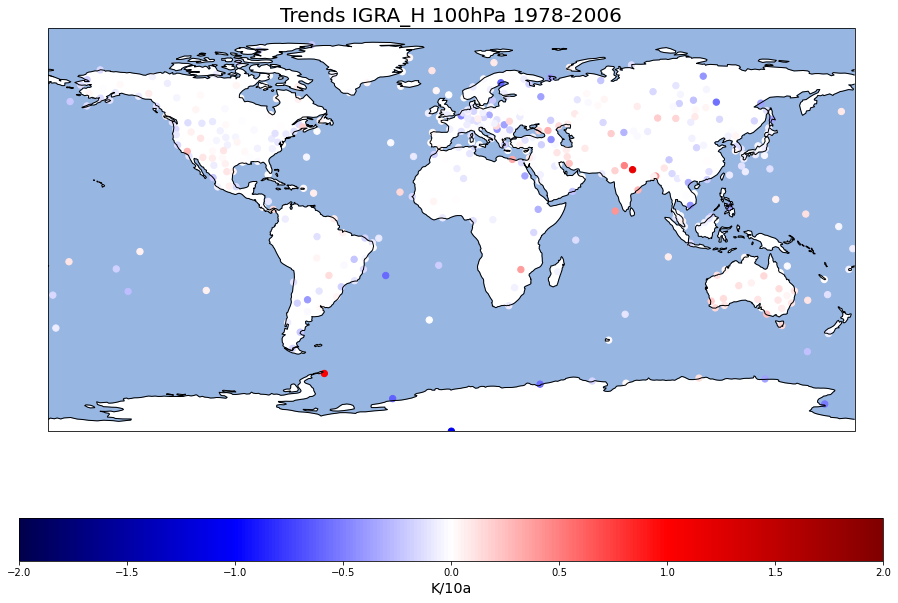

In [10]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib as mpl

ax = plt.axes([0, 0, 1, 1], projection=ccrs.PlateCarree())
ax.add_feature(cfeature.OCEAN, zorder=0)
ax.coastlines()

da = igra.dropna()
reduced = np.asarray(da['station_name'])
longitudes = list(da['location_longitude'])
latitudes = list(da['location_latitude'])
plt.scatter(longitudes, latitudes, s=40, alpha=1,
            c= da['station_name'],
            cmap='seismic',
            vmin=-2,
            vmax=2)
plt.colorbar(orientation='horizontal', label='K/10a')
plt.title('Trends IGRA_H 100hPa 1978-2006')
plt.savefig('IGRA_100hPa_1978_2006_Trend.png')




In [11]:
da['station_name']*3650

59      -319.228
67      -759.201
89      -555.898
91      -81.1182
99      -182.975
          ...   
4822     179.013
4835     3765.76
4838      218.52
4839     28.4268
5625   -0.268902
Name: station_name, Length: 394, dtype: object

In [12]:
reduced.min()

-1.0927977002580942

In [13]:
import matplotlib.cm as cm
# colors = np.array(colors, dtype=np.float)
# col = [cm.tab20(x) for x in range(len(reduced))]
# col = [cm.tab20(x/len(reduced)) for x in range(len(reduced))]


In [14]:
col

NameError: name 'col' is not defined

In [ ]:
def savetoarray(file, dataset: str='IGRA', dest: str='./temp100/'):
    yr = file.split('/')[5]
    plev = 10000
    chunk = pd.read_csv(file, header=12, index_col=False, usecols=['station_name', 'observed_value', 'air_pressure'])
    stations = chunk.station_name.drop_duplicates()
    for i in stations:
        if not os.path.isfile( dest + dataset + '_' + i + '_' + yr + '_' + str(plev) + ".p"):
            da = chunk[chunk.station_name == i]
            da = da[da.air_pressure == plev]
            pickle.dump( np.asarray(da.observed_value), open( dest + dataset + '_' + i + '_' + yr + '_' + str(plev) + ".p", "wb" ))

In [ ]:
if __name__ == '__main__':
    pool = multiprocessing.Pool(processes=20)
    result_list = pool.map(savetoarray, files[10:20])
    print(result_list)

In [ ]:
print('!')

In [ ]:
lon = igra.report_timestamp.drop_duplicates()
lat = igra.location_longitude.drop_duplicates()
print(len(lon))
print(len(lat))

In [ ]:
# IGRA and its harmonized version
for i in range(len(files)):
    print(i)
    if i == 0:
#         igra = pandas.read_csv(files[i], header=12)
        igrah = pandas.read_csv(files_h[i], header=12)
    else:
#         igra = igra.append(pandas.read_csv(files[i], header=12))
        igrah = igrah.append(pandas.read_csv(files_h[i], header=12))

In [ ]:
preslist = [10000, 20000, 50000, 85000,]
for i in range(len(preslist)):
    c = comp[comp.plev == preslist[i]]
    c.time = pandas.to_datetime(c.time, utc=True)
    xax = np.asarray(c.time)
    
    selected = c.ta
    datlen = len(selected)
    coefficients, residuals, _, _, _ = np.polyfit(range(datlen),selected,1,full=True)
    mse = residuals[0]/(datlen)
    nrmse = np.sqrt(mse)/(selected.max() - selected.min())

    fig, (ax1) = plt.subplots(1, 1)
    ax1.plot(xax, np.asarray(selected), label = 'COMP', alpha=0.7)
    ax1.plot(xax, [coefficients[0]*x + coefficients[1] for x in range(len(selected))], label = 'COMP trend')
    ax1.set(xlabel ='time [multiples of 12h]', ylabel='temperature [K]', title='COMP Trend '+str(int(preslist[i]/100))+'hPa '+loc)
    textstr = 'Slope ' + str(coefficients[0]) +'\n'+'NRMSE: ' + str(nrmse)
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax1.text(0.03, 0.95, textstr, transform=ax1.transAxes, fontsize=16, verticalalignment='top', bbox=props)


    ax1.legend( loc='best')
    plt.show()
    plt.close(fig)